# Basic integration with google drive and using basic packages with tensorflow!!!

In [191]:
import os
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

In [0]:
# ! pip install psutil 
# ! pip install keras==2.1.4
# ! pip install -U -q PyDrive

In [0]:
import keras
import psutil
import pandas as pd
import tensorflow as tf
from google.colab import auth
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [194]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Setting up Google drive authentication and setting system for proper google drive access...

In [0]:
# need to be done only once
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [196]:
#we will use the google drive work as a local drive and save the model
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmp3mcvsv25/pubring.gpg' created
gpg: /tmp/tmp3mcvsv25/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [197]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


··········


In [198]:
# Create a directory 'MyModelSummary' and mount Google Drive using that directory.
!mkdir -p ICSummary
!google-drive-ocamlfuse -o nonempty ICSummary

#create a directory to save model summary in the mounted directory,this is where we save all the model specifications
#1.the architecture of the model, allowing to re-create the model
#2.the weights of the model
#3.the training configuration (loss, optimizer)
#4.the state of the optimizer, allowing to resume training exactly where you left off.
!mkdir /content/ICSummary/
!chmod 777 /content/ICSummary/

mkdir: cannot create directory ‘/content/ICSummary/’: File exists
chmod: changing permissions of '/content/ICSummary/': Input/output error


In [199]:
! ls

datalab  dataset  dataset.zip  Graph  ICSummary  inceptionv3.hdf5


### Now we have every thing setup... Its time to roll the ball with our initial dataset..

In [0]:
# file1 = drive.CreateFile({'id':'1Pqjs7c5MAgPQLiMA3YR8dFg_YHLnPdlO'})
# file1.GetContentFile('dataset.zip')

In [0]:
#@title Looking at available data and see if it is already expanded
# !unzip dataset.zip -d ./

#### Writing the helper and cleaning fucntions for processing the data set!

In [0]:
import hashlib
import numpy as np
from glob import glob
from random import shuffle
from skimage.color import gray2rgb
from scipy.misc import imread, imsave

#keras imports

from keras.applications import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications import xception

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers.core import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard

# for class behaviour
from sklearn.metrics import accuracy_score, confusion_matrix

# For some plotting
from keras.utils import plot_model
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import seaborn as sns

# Stop training if validation loss doesn't improve for 10 epochs
earlystop = EarlyStopping(monitor = "val_loss", 
                          patience = 10, 
                          verbose = 1, 
                          mode = "auto")

# Save the best model after every epoch
checkpoint = ModelCheckpoint(filepath = "inceptionv3.hdf5", 
                             verbose = 1, 
                             save_best_only = True)

# Reduce the learning rate after validation loss plateaus
reducelr = ReduceLROnPlateau(monitor = "val_loss", 
                             factor = 0.2,
                             patience = 5)

TARGET_SIZE = (299, 299) # Input shape for Inception v3
BATCH_SIZE = 32 # Batch size for training


In [0]:
# Function to clean repetitive images
def clean_train(train_folder):
    '''Removes duplicates in train folder where the same images appears in
    more than one class'''
    hashes = {}
    labels = {}

    print("computing md5 of training data")

    for fname in glob(train_folder+"/*/*.jpg"):
        labels[fname] = fname.split("//")[-2]
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()  
        if h in hashes:
            hashes[h].append(fname)
        else:
            hashes[h] = [fname]
    
    # Find duplicates
    repeated = sum(1 for k,v in hashes.items() if len(v) > 1 )
    print("Files appearing more than once in train: ", repeated)
    
    del_files = []
    
    # Find duplicate images with different class names
    for k,v in hashes.items():
        if len(v) > 1:
            c = set([labels[x] for x in v])
            if len(c) > 1:
                del_files = del_files.append(v)
    
    for x in del_files:
        os.remove(x)

    print(len(del_files), "images deleted from training set")

In [0]:
# Function for processing training images with classes
def process_train_images(train_folder):
    ''' Function to convert training images to 3 channels (for images having
    4 channels or less than 3 channels)''' 
    
    classes = os.listdir(train_folder)
    for cla in classes:
        cla_path = os.path.join("dataset", "train", cla)
        for img in os.listdir(cla_path):
            img_path = os.path.join("dataset", "train", cla, img)
            img_file = imread(img_path)
            if len(img_file.shape) < 3:
                img_file = gray2rgb(img_file)
                img_file = img_file.astype(np.float32, copy = False)
                imsave(img_path, img_file)
            if len(img_file.shape) == 4:
                img_file = img_file[:,:,:-1]
                img_file = img_file.astype(np.float32, copy = False)
                imsave(img_path, img_file)
                

In [0]:
# Function for processing test images
def process_test_images(test_folder):
    ''' Function to convert test images to 3 channels (for images having
    4 channels or less than 3 channels)
    Convert from 4 channel inputs like : CMYK and Alpha to 3 channels'''
    for img in os.listdir(test_folder):
        img_path = os.path.join(test_folder, img)
        img_file = imread(img_path)
        if len(img_file.shape) < 3:
            img_file = gray2rgb(img_file)
            img_file = img_file.astype(np.float32, copy = False)
            imsave(img_path, img_file)
        if len(img_file.shape) == 4:
            img_file = img_file[:,:,:-1]
            img_file = img_file.astype(np.float32, copy = False)
            imsave(img_path, img_file)

In [0]:
# Function to seek images which are available in both train and test data
def find_leak(train_folder, test_folder):
    '''Finds images present in both training and test set'''

    hashes = {}
    labels = {}

    print("computing md5 of training data")

    for fname in glob(train_folder+"/*/*.jpg"):
        labels[fname] = fname.split("//")[-2]
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()  
        if h in hashes:
            hashes[h].append(fname)
        else:
            hashes[h] = [fname]

    print("comparing training and test set")
    
    leaks = []
    for fname in glob(test_folder+"/*.jpg"):
        h = hashlib.md5(open(fname,"rb").read()).hexdigest()
        if h in hashes:
            leaks.append((fname.split("//")[-1],hashes[h][0].split("//")[-2]))

    print("Number of test images present in train:{}".format(len(leaks)))
    return leaks

In [0]:
# Function to create validation set of images from the data
def create_val_set(val_size):
    '''Function to create a validation set from training images'''
    if not os.path.exists("dataset//valid"):
        os.makedirs("dataset//valid")
    class_list = os.listdir("dataset//train")
    for cla in class_list:
        if os.path.exists(os.path.join("dataset", "valid", cla)):
            if len(os.listdir(os.path.join("dataset", "valid", cla))) == 0:
                new_files = os.listdir(os.path.join("dataset", "train", cla))
                new_files = remove_percentage(new_files, val_size)
                for nf in new_files:
                    os.rename(os.path.join("dataset", "train", cla, nf), 
                              os.path.join("dataset", "valid", cla, nf))
            else:
                new_files = os.listdir(os.path.join("dataset", "valid", cla))
                for nf in new_files:
                    os.rename(os.path.join("dataset", "valid", cla, nf),
                              os.path.join("dataset", "train", cla, nf))
                new_files = os.listdir(os.path.join("dataset", "train", cla))
                new_files = remove_percentage(new_files, val_size)
                for nf in new_files:
                    os.rename(os.path.join("dataset", "train", cla, nf), 
                              os.path.join("dataset", "valid", cla, nf))
        else:
            os.makedirs(os.path.join("dataset", "valid", cla))
            new_files = os.listdir(os.path.join("dataset", "train", cla))
            new_files = remove_percentage(new_files, val_size)
            for nf in new_files:
                os.rename(os.path.join("dataset", "train", cla, nf), 
                          os.path.join("dataset", "valid", cla, nf))

In [0]:
# Pre-processing function for Inception v3 model
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def remove_percentage(list_a, percentage):
    ''' Function to randomly pick x percentage from a list'''
    shuffle(list_a)
    count = int(len(list_a) * percentage)
    if not count: 
        return []
    list_a[-count:], list_b = [], list_a[-count:]
    return list_b
  
# Funciton for loading the model in Keras. Options can be defined as string.
def define_model(premodel='resnet'):
  
  
    if premodel == 'resnet':
      base_model = ResNet50(include_top=False, 
                            weights='imagenet', 
                            input_shape=(299, 299, 3), 
                            pooling=None, 
                            classes=1000)
      
    elif premodel == 'inception':
      base_model = InceptionV3(weights = "imagenet", 
                           include_top = False, 
                           input_shape = (299, 299, 3))

    elif premodel == 'xception':
      base_model = xception.Xception(weights='imagenet', 
                                     include_top=False, 
                                      input_shape = (299, 299, 3))
      
      
    base_model.layers.pop()
    for i in range(len(base_model.layers)):
        base_model.layers[i].trainable = False
        
    add_model = Sequential()
    add_model.add(Flatten(input_shape = base_model.output_shape[1:]))
    add_model.add(Dense(256, activation = "relu"))
    add_model.add(Dense(len(os.listdir("dataset//train")), activation="softmax"))
    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
    model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9),
              metrics = ["accuracy"])
    model.summary()
    return(model)


In [209]:
# Cleaning train data for replications
clean_train("dataset//train")

#Check whether any file appears in both training and test set
_ = find_leak("dataset//train", "dataset//test")

#Convert all training images to 3 channels
process_train_images("dataset//train")

#Convert all test images to 3 channels
process_test_images("dataset//test//data")

# Creating Validation dataset
create_val_set(0.2)

computing md5 of training data
Files appearing more than once in train:  27
0 images deleted from training set
computing md5 of training data
comparing training and test set
Number of test images present in train:0


In [210]:
#Load the pre-trained Inception V3 model
model = define_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
# lets plot the model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
train_datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        #,preprocessing_function = preprocess_input
)

test_datagen = ImageDataGenerator()
    #preprocessing_function = preprocess_input)
  

In [214]:
train_generator = train_datagen.flow_from_directory(
        "dataset//train",
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical")

Found 4350 images belonging to 12 classes.


In [215]:
validation_generator = train_datagen.flow_from_directory(
        "dataset//valid", 
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical")

Found 1083 images belonging to 12 classes.


In [216]:
test_generator = test_datagen.flow_from_directory(
        "dataset//test", 
        target_size = TARGET_SIZE, 
        batch_size = BATCH_SIZE, 
        class_mode = "categorical", 
        shuffle = False)

Found 3375 images belonging to 1 classes.


In [0]:
#!mkdir Graph|chmod 777 Graph
tbCallBack = keras.callbacks.TensorBoard(log_dir='/content/Graph', 
                                         histogram_freq=0, 
                                         write_graph=True, 
                                         write_images=True)

earlystop = EarlyStopping(monitor = "val_loss", 
                          patience = 10, 
                          verbose = 1, 
                          mode = "auto")

checkpoint = ModelCheckpoint(filepath = "inceptionv3.hdf5", 
                             verbose = 1, 
                             save_best_only = True)

reducelr = ReduceLROnPlateau(monitor = "val_loss", 
                             factor = 0.2,
                             patience = 2)

In [218]:
model.fit_generator(
        generator = train_generator,
        epochs = 5,
        callbacks = [checkpoint, earlystop, reducelr,tbCallBack],
        validation_data = validation_generator,
        verbose = 1)

Epoch 1/5
136/136 [==============================] - 149s 1s/step - loss: 2.4735 - acc: 0.1752 - val_loss: 2.5243 - val_acc: 0.1468

Epoch 00001: val_loss improved from inf to 2.52429, saving model to inceptionv3.hdf5
Epoch 2/5
136/136 [==============================] - 134s 988ms/step - loss: 2.2038 - acc: 0.2644 - val_loss: 2.3456 - val_acc: 0.2078

Epoch 00002: val_loss improved from 2.52429 to 2.34556, saving model to inceptionv3.hdf5
Epoch 3/5
 83/136 [=================>............] - ETA: 42s - loss: 2.0699 - acc: 0.3259

136/136 [==============================] - 137s 1s/step - loss: 2.0519 - acc: 0.3310 - val_loss: 2.2611 - val_acc: 0.2308

Epoch 00003: val_loss improved from 2.34556 to 2.26107, saving model to inceptionv3.hdf5
Epoch 4/5
136/136 [==============================] - 136s 997ms/step - loss: 1.9215 - acc: 0.3821 - val_loss: 2.2319 - val_acc: 0.2576

Epoch 00004: val_loss improved from 2.26107 to 2.23186, saving model to inceptionv3.hdf5
Epoch 5/5
100/136 [=====================>........] - ETA: 29s - loss: 1.8407 - acc: 0.4181

136/136 [==============================] - 136s 1s/step - loss: 1.8419 - acc: 0.4117 - val_loss: 2.1168 - val_acc: 0.2964

Epoch 00005: val_loss improved from 2.23186 to 2.11675, saving model to inceptionv3.hdf5


In [219]:
predictions = model.predict_generator(
        test_generator,
        verbose = 1)

106/106 [==============================] - 70s 663ms/step


In [0]:
predictions = np.argmax(predictions, axis = 1)
labels = train_generator.class_indices
predictions = [list(labels.keys())[list(labels.values()).index(i)] for i in predictions]

In [221]:
predictions[1:10]

['Black Panther',
 'Spiderman',
 'Spiderman',
 'Spiderman',
 'Iron Man',
 'Superman',
 'Black Panther',
 'Superman',
 'Catwoman']

In [222]:
labels

{'Ant-Man': 0,
 'Aquaman': 1,
 'Avengers': 2,
 'Batman': 3,
 'Black Panther': 4,
 'Captain America': 5,
 'Catwoman': 6,
 'Ghost Rider': 7,
 'Hulk': 8,
 'Iron Man': 9,
 'Spiderman': 10,
 'Superman': 11}

In [223]:
!pip install lime
from lime import lime_image

    100% |████████████████████████████████| 266kB 7.7MB/s 
  Running setup.py bdist_wheel for lime ... - \ done
  Stored in directory: /content/.cache/pip/wheels/bb/f7/e7/a740bfd09d31d46dee9db7bbef07f12629d5249401879b4ec1
Successfully built lime
proto-google-cloud-logging-v2 0.91.3 has requirement oauth2client<4.0dev,>=2.0.0, but you'll have oauth2client 4.1.2 which is incompatible.
proto-google-cloud-error-reporting-v1beta1 0.15.3 has requirement oauth2client<4.0dev,>=2.0.0, but you'll have oauth2client 4.1.2 which is incompatible.
proto-google-cloud-datastore-v1 0.90.4 has requirement oauth2client<4.0dev,>=2.0.0, but you'll have oauth2client 4.1.2 which is incompatible.
nbconvert 5.3.1 has requirement pandocfilters>=1.4.1, but you'll have pandocfilters 1.3.0 which is incompatible.
google-gax 0.15.16 has requirement future<0.17dev,>=0.16.0, but you'll have future 0.15.2 which is incompatible.
google-cloud 0.32.0 has requirement google-cloud-bigquery<0.29dev,>=0.28.0, but you'll ha

In [224]:
!ls /content/dataset/valid/Catwoman/

cax_catwoman_train2309.jpg  cax_catwoman_train2422.jpg
cax_catwoman_train2310.jpg  cax_catwoman_train2423.jpg
cax_catwoman_train2313.jpg  cax_catwoman_train2426.jpg
cax_catwoman_train2323.jpg  cax_catwoman_train2432.jpg
cax_catwoman_train2325.jpg  cax_catwoman_train2436.jpg
cax_catwoman_train2326.jpg  cax_catwoman_train2447.jpg
cax_catwoman_train2334.jpg  cax_catwoman_train2449.jpg
cax_catwoman_train2342.jpg  cax_catwoman_train2451.jpg
cax_catwoman_train2351.jpg  cax_catwoman_train2452.jpg
cax_catwoman_train2352.jpg  cax_catwoman_train2459.jpg
cax_catwoman_train2359.jpg  cax_catwoman_train2461.jpg
cax_catwoman_train2363.jpg  cax_catwoman_train2465.jpg
cax_catwoman_train2382.jpg  cax_catwoman_train2471.jpg
cax_catwoman_train2386.jpg  cax_catwoman_train2476.jpg
cax_catwoman_train2394.jpg  cax_catwoman_train2477.jpg
cax_catwoman_train2400.jpg  cax_catwoman_train2478.jpg
cax_catwoman_train2402.jpg  cax_catwoman_train2484.jpg
cax_catwoman_train2405.jpg  cax_catwoman_train2493.jpg
cax_catwom

In [225]:
data_dir = '/content/dataset/'
valid = []
for file in os.listdir('/content/dataset/valid'):
    valid.append(['valid/{}'.format(file), file])
valid = pd.DataFrame(valid, columns=['filepath', 'file'])
print(valid.head(2))
valid.shape

            filepath         file
0     valid/Catwoman     Catwoman
1  valid/Ghost Rider  Ghost Rider


(12, 2)

In [226]:
glob('/content/dataset/valid/Catwoman/')

['/content/dataset/valid/Catwoman/']

In [230]:
np.random.choice(glob('/content/dataset/valid/Catwoman/*'),1)[0]

'/content/dataset/valid/Catwoman/cax_catwoman_train2351.jpg'

In [0]:
def read_img(filepath, size):
    random_image = np.random.choice(glob(os.path.join(data_dir, filepath,'*')),1)[0]
    img = image.load_img(random_image, target_size=size)
    img = image.img_to_array(img)
    return img

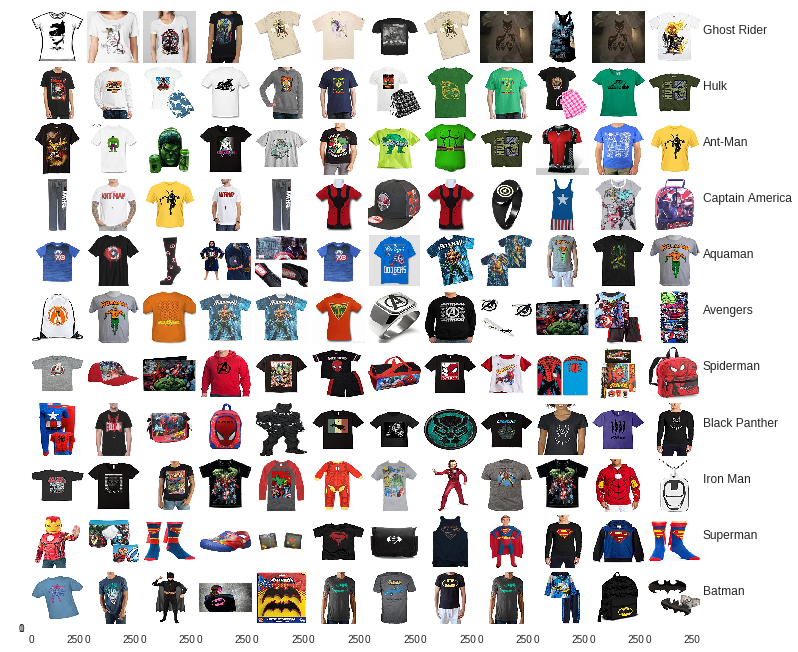

In [234]:
CATEGORIES = valid.file.values
NUM_CATEGORIES = len(CATEGORIES)

fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
  for j in range(NUM_CATEGORIES-1):
    for filepath in valid[valid['file'] == category]['filepath'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (299, 299))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(310, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();



In [237]:
predictions = model.predict_generator(
        validation_generator,
        verbose = 1)
predictions = np.argmax(predictions, axis = 1)
labels = validation_generator.class_indices
predictions = [list(labels.keys())[list(labels.values()).index(i)] for i in predictions]



34/34 [==============================] - 32s 938ms/step


In [256]:
predictions[2:20]

['Spiderman',
 'Superman',
 'Superman',
 'Iron Man',
 'Catwoman',
 'Superman',
 'Spiderman',
 'Spiderman',
 'Hulk',
 'Superman',
 'Avengers',
 'Superman',
 'Avengers',
 'Hulk',
 'Catwoman',
 'Catwoman',
 'Iron Man',
 'Spiderman']

In [239]:
validation_generator.classes

array([ 0,  0,  0, ..., 11, 11, 11], dtype=int32)

In [0]:

cnf_matrix = confusion_matrix([list(labels.keys())[list(labels.values()).index(i)] for i in validation_generator.classes], predictions)
abbreviation = validation_generator.class_indices

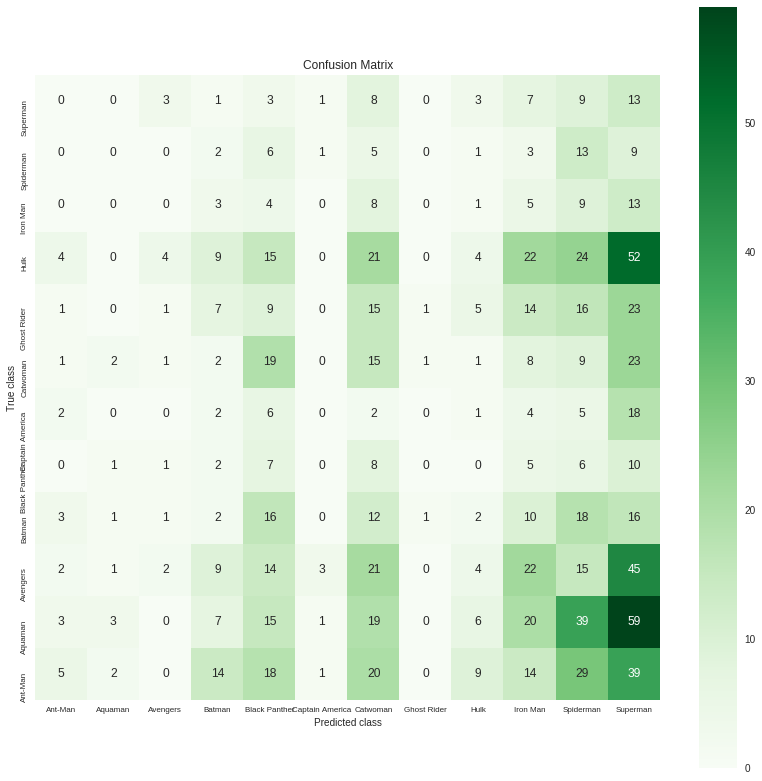

In [260]:
fig, ax = plt.subplots(1,figsize = (14,14))
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True, fmt = 'd')
ax.set_xticklabels(abbreviation, fontsize=8)
ax.set_yticklabels(abbreviation, fontsize=8)
ax.set_aspect('equal')
plt.title('Confusion Matrix')
plt.ylabel('True class',fontsize=10)
plt.xlabel('Predicted class',fontsize=10)
fig.savefig('Confusion matrix.png', dpi=600)
plt.show();